# Multiobjective optimization

So far, we have only looked at one objective - How much gold is present at the dig site.
But Ms. Dixon now points out that she can find more gold if the dig site is close to the
camp, so she can get back and forth more quickly. After some discussion, we find out that
we can't agree on a balance between the two objectives - how "expensive" travel distance
is depends on a lot of parameters that we can't predict, like which vehicle we use and how expensive fuel is.

What we can agree on is that, for two dig sites $A$ and $B$:
* If $A$ is closer to the camp than $B$, while not having a lower gold content than $B$, $A$ is preferred.
* If $A$ has a higher gold content than $B$, while not being farther from the camp than $B$, $A$ is preferred.

In either case, we say that $A$ dominates $B$. If we make a `ProcessOptimizer` that optimizes two objectives, it tries to find the points that aren't dominated by any other dig sites. These are the sites we can't immediately rule out as the best places to dig. Such sites are called Pareto efficient, and the set of all such sites is called the Pareto front.

We start by loading `ModelSystem`s for how much gold is present at a dig site, and how far
it is from the camp situated at $(4, 10)$.

Text(4, 10, 'Camp')

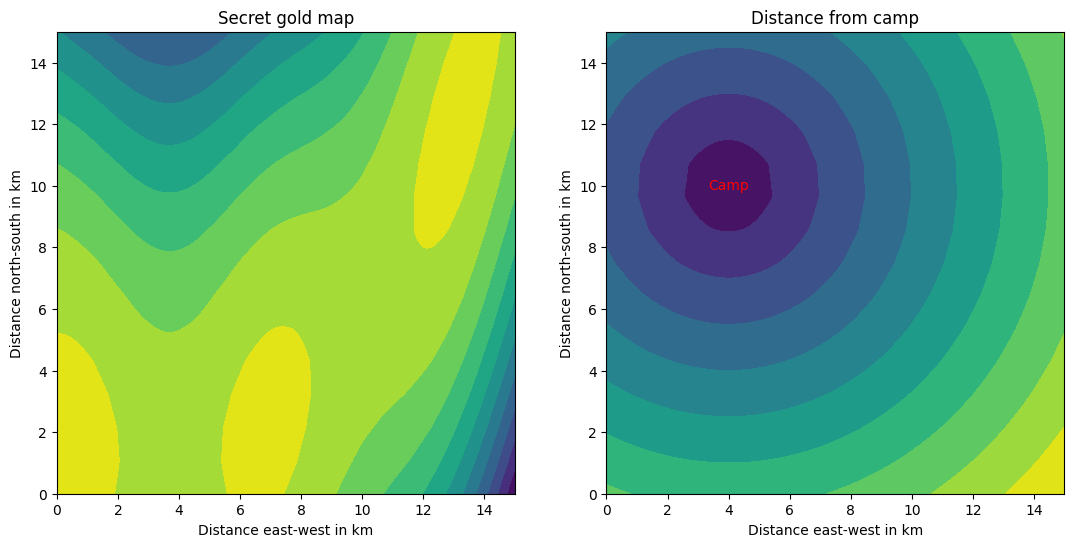

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import ProcessOptimizer
from ProcessOptimizer.model_systems import get_model_system

gold_model_system = get_model_system('gold_map')
distance_model_system = get_model_system('distance_map')
bounds = gold_model_system.space.bounds


x_list = np.linspace(bounds[0][0],bounds[0][1],100)
y_list = np.linspace(bounds[1][0],bounds[1][1],15,100)
(x_mesh,y_mesh) = np.meshgrid(x_list,y_list)
gold_mesh = [[-gold_model_system.get_score((x,y)) for (x,y) in zip(x_vec,y_vec)] 
              for (x_vec,y_vec) in zip(x_mesh,y_mesh)]

figure = plt.figure()
figure.set_size_inches(13,6)
gold_plot = figure.add_subplot(1,2,1)
distance_plot = figure.add_subplot(1,2,2)
plot = gold_plot.contourf(x_mesh,y_mesh,gold_mesh,10)
plot.axes.set_xlabel("Distance east-west in km")
plot.axes.set_ylabel("Distance north-south in km")
plot.axes.set_title("Secret gold map")

distance_mesh = [[distance_model_system.get_score((x,y)) for (x,y) in zip(x_vec,y_vec)] 
              for (x_vec,y_vec) in zip(x_mesh,y_mesh)]
plot = distance_plot.contourf(x_mesh,y_mesh,distance_mesh,10)
plot.axes.set_xlabel("Distance east-west in km")
plot.axes.set_ylabel("Distance north-south in km")
plot.axes.set_title("Distance from camp")
distance_plot.text(4,10,"Camp",color='red', horizontalalignment='center', verticalalignment='center')

We can now create our `ProcessOptimizer` that tries to find the non-dominated dig sites, 
ask it for 10 dig sites and dig there.

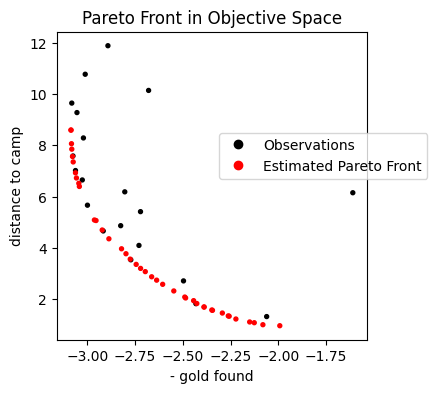

In [12]:
opt = ProcessOptimizer.Optimizer(gold_model_system.space, n_initial_points=4, n_objectives=2)

for i in range(20):
    new_dig_site = opt.ask()
    gold_found = gold_model_system.get_score(new_dig_site)
    distance = distance_model_system.get_score(new_dig_site)
    result_list = opt.tell(new_dig_site, [gold_found, distance])



Each dig site has a distance to the camp and an amount of gold found. We can plot the 

In [ ]:
ProcessOptimizer.plot_Pareto(optimizer=opt, figsize = [4,4], objective_names=["- gold found", "distance to camp"]);